# Electricity Demand Forecasting

In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

This notebook is used to compare the walk forward validation steps for the the two models that consistently provided the best results in the initial model evaluations.  Both models use the daily demand data.  The notebook compares the prediction accuracy of a SARIMAX model and an Prophet model.  

The SARIMAX model only uses the high temperatures for two cities as exogenous data.  The other data columns did not provide useful input based on the coefficient p-values.

The Prophet model uses all the exogenous inputs.

Each model is walked through 20 validation steps and the results are plotted at the end of the notebook.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    2A. [Clean Data Frame](#clean_data)<br>
    2B. [Extend Exogenous Data](#extend_dow)<br>
3. [Walk Forward Validation](#walk_forward_validation)<br>
    3A. [SARIMAX Walk Forward Validation](#walk_forward_sarimax)<br>
    3B. [Prophet Walk Forward Validation](#walk_forward_prophet)<br>
4. [Validation Results](#results_plot)


----

### <a id='import'> 1. Import Modules</a>

----

In [1]:
import sys

import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel
from fbprophet import Prophet

sys.path.append('../src')
from EF_tools import prophet_walk_forward_val, sarimax_walk_forward_val

In [2]:
# Turn off some of the warnings
warnings.filterwarnings('ignore')

----

### <a id='read_data'>2. Data Import </a>

----

In [3]:
# Read the datafile produced using the EF_EDA_CleanSplitAgg notebook.
data_file = '../data/big_demand_temp_train_by_day.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


----

#### <a id='clean_data'> 2.A Clean the data frame </a>

----

In [5]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2015-07-06 to 2017-11-03
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day_demand  852 non-null    float64
 1   CA_pop      852 non-null    float64
 2   la_high     852 non-null    float64
 3   sd_high     852 non-null    float64
 4   sj_high     852 non-null    float64
 5   sf_high     852 non-null    float64
 6   sac_high    852 non-null    float64
 7   f_high      852 non-null    float64
 8   DOW         852 non-null    float64
dtypes: float64(9)
memory usage: 66.6 KB


In [6]:
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### <a id='extend_dow'>2B. Extending Exogenous Regressors To Include Day Of Week </a>

In [7]:
days = full_df['DOW']
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names
new_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,Mon,Tue,Wed,Thur,Fri,Sat,Sun
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0,1,0,0,0,0,0,0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0,0,1,0,0,0,0,0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0,0,0,1,0,0,0,0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0,0,0,0,1,0,0,0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0,0,0,0,0,1,0,0


----
----
### <a id='walk_forward_val'>3. Walk Forward Validation</a>
----

In [8]:
# Create a log demand column for the sarimax model
full_df['log_demand'] = np.log(full_df['day_demand'])

# Create the date series and the demand columns for the prophet model
full_df['ds'] = full_df.index
full_df['y'] = full_df['day_demand']

----

#### <a id='walk_forward_sarimax'> 3A. SARIMAX Walk Forward Validation</a>

----

In [9]:
exog_columns = ['la_high','f_high']
results = sarimax_walk_forward_val(full_df, 432, 21, exog_columns, 20)

Step 1 starting at index 432
Step 2 starting at index 453
Step 3 starting at index 474
Step 4 starting at index 495
Step 5 starting at index 516
Step 6 starting at index 537
Step 7 starting at index 558
Step 8 starting at index 579
Step 9 starting at index 600
Step 10 starting at index 621
Step 11 starting at index 642
Step 12 starting at index 663
Step 13 starting at index 684
Step 14 starting at index 705
Step 15 starting at index 726
Step 16 starting at index 747
Step 17 starting at index 768
Step 18 starting at index 789
Step 19 starting at index 810
Step 20 starting at index 831


----

#### <a id='walk_forward_prophet'> 3B. Prophet Walk Forward Validation</a>

----

In [10]:
exog_columns = ['CA_pop', 'la_high', 'sd_high', 'f_high', 'sj_high', 'sf_high', 'sac_high']
results_prophet = prophet_walk_forward_val(full_df, 432, 21, exog_columns, 20)

Step 1 starting at index 432


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-09-10T00:00:00.000000000 2016-09-10T00:00:00.000000000
Step 2 starting at index 453


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-10-01T00:00:00.000000000 2016-10-01T00:00:00.000000000
Step 3 starting at index 474


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-10-22T00:00:00.000000000 2016-10-22T00:00:00.000000000
Step 4 starting at index 495


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-11-12T00:00:00.000000000 2016-11-12T00:00:00.000000000
Step 5 starting at index 516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-12-03T00:00:00.000000000 2016-12-03T00:00:00.000000000
Step 6 starting at index 537


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-12-24T00:00:00.000000000 2016-12-24T00:00:00.000000000
Step 7 starting at index 558


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-01-14T00:00:00.000000000 2017-01-14T00:00:00.000000000
Step 8 starting at index 579


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-02-04T00:00:00.000000000 2017-02-04T00:00:00.000000000
Step 9 starting at index 600


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-02-25T00:00:00.000000000 2017-02-25T00:00:00.000000000
Step 10 starting at index 621


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-03-18T00:00:00.000000000 2017-03-18T00:00:00.000000000
Step 11 starting at index 642


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-04-08T00:00:00.000000000 2017-04-08T00:00:00.000000000
Step 12 starting at index 663


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-04-29T00:00:00.000000000 2017-04-29T00:00:00.000000000
Step 13 starting at index 684


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-05-20T00:00:00.000000000 2017-05-20T00:00:00.000000000
Step 14 starting at index 705


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-06-10T00:00:00.000000000 2017-06-10T00:00:00.000000000
Step 15 starting at index 726


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-07-01T00:00:00.000000000 2017-07-01T00:00:00.000000000
Step 16 starting at index 747


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-07-22T00:00:00.000000000 2017-07-22T00:00:00.000000000
Step 17 starting at index 768


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-08-12T00:00:00.000000000 2017-08-12T00:00:00.000000000
Step 18 starting at index 789


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-09-02T00:00:00.000000000 2017-09-02T00:00:00.000000000
Step 19 starting at index 810


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-09-23T00:00:00.000000000 2017-09-23T00:00:00.000000000
Step 20 starting at index 831
2017-10-14T00:00:00.000000000 2017-10-14T00:00:00.000000000


----

### <a id='results_plot'> 4. Validation Results</a>

----

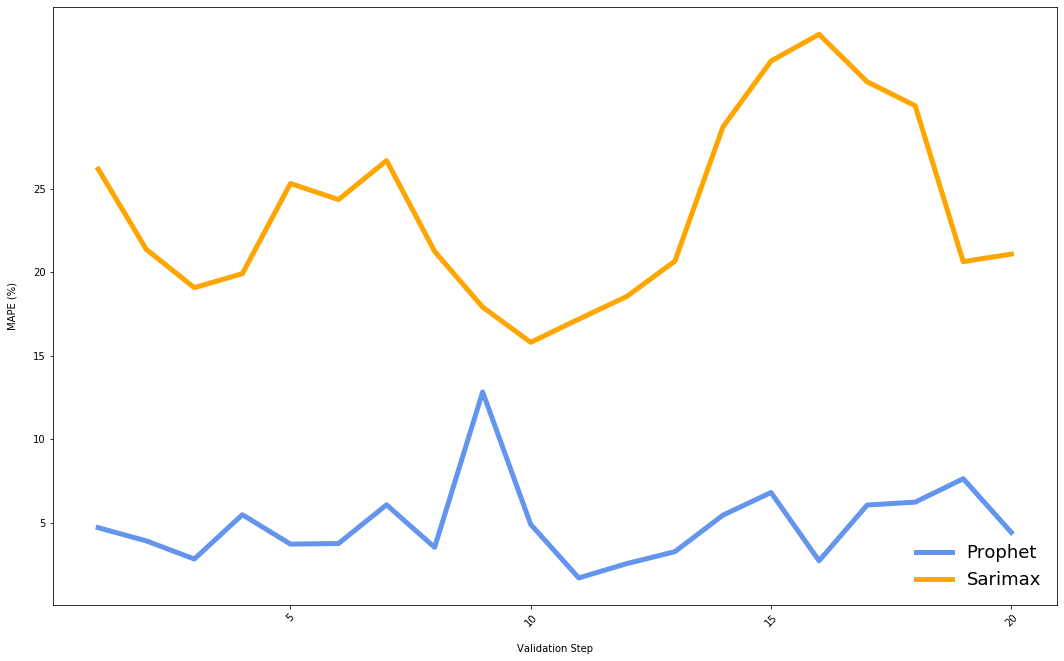

In [11]:
# Plot the validation results for both models
fig = plt.figure(figsize=[18,11])

# These lines help make a transparent background for plot files
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

# These definitions help keep font sizing consistent
SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.title('Walk Forward Validation\n', fontsize=18)
plt.xlabel('\nValidation Step')
plt.ylabel('MAPE (%)\n')
plt.legend(loc='lower right')

# Plot the results for the prophet model
prophet_results_x = [x[0].date() for x in results_prophet]
prophet_results_x = pd.DatetimeIndex(prophet_results_x)

xticks = prophet_results_x[4::5]
xlabels = ['5', '10', '15', '20', '10','12']
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks([5, 10, 15, 20, 25], ['5', '10', '15', '20', '25'])

prophet_results_y = [x[1] for x in results_prophet]
prophet_timestamps = [x[0].timestamp() for x in results_prophet]
plt.plot(prophet_results_x, prophet_results_y, label='Prophet', c='cornflowerblue', linewidth=5)


# Plot the SARIMAX validation results
sarima_results_x = [x[0].date() for x in results]
sarima_results_y = [x[1] for x in results]
sarima_timestamps = [x[0].timestamp() for x in results]

plt.plot(sarima_results_x, sarima_results_y,label='Sarimax', c='orange', linewidth=5)
leg = plt.legend(loc='lower right', facecolor=None)
leg.get_frame().set_alpha(0.0)

# Save the figure for presentations
plt.savefig('walk_validation_errors.png', Transparent=True)
